### venv location:
activate the following: `~/cryptic-nn/src/fine-tuning/esmc-venv/bin/activate`

In [1]:
from transformers import AutoTokenizer
import torch
import numpy as np
import functools
from sklearn import metrics
from torch.utils.data import DataLoader
import sys

sys.path.append('/home/skrhakv/cryptoshow-analysis/src/utils')
sys.path.append('/home/skrhakv/cryptic-nn/src') 
import finetuning_utils # download from https://github.com/skrhakv/cryptic-finetuning/blob/master/src/finetuning_utils.py
from finetuning_utils import FinetunedEsmModel
import eval_utils
from eval_utils import CryptoBenchClassifier

MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_PATH = f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model.pt'


In [3]:
SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False) #, map_location=torch.device('cpu'))

# scPDB-enhanced model
Run scPDB-enhanced model on LIGYSIS (version WITH ions).

In [4]:
MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model-enhanced-scPDB.pt'

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings-enhanced-scPDB'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

predicted_binding_sites = {}
ranks = {}
predicted_binding_sites_without_smoothing = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)

    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        decision_threshold=DECISION_THRESHOLD,
        eps=4,
        min_samples=2,
        method='dbscan'
    )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    this_predicted_binding_sites = []
    this_predicted_binding_sites_without_smoothing = []
    this_ranks = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        this_predicted_binding_sites_without_smoothing.append((cluster_residue_indices, 'finetuned model without smoothing'))
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 

        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        this_predicted_binding_sites.append((enhanced_residue_indices, 'finetuned model with smoothing'))
        this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
    
    # sort by the rank:
    this_predicted_binding_sites = [pocket for rank, pocket in sorted(zip(this_ranks, this_predicted_binding_sites), key=lambda x: x[0], reverse=True)]
    predicted_binding_sites[protein_id] = this_predicted_binding_sites
    predicted_binding_sites_without_smoothing[protein_id] = this_predicted_binding_sites_without_smoothing
    
if not PRECALCULATED:
    import numpy as np
    for protein_id in prediction_scores.keys():
        np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

    import pickle
    for protein_id in sequences.keys():
        filename = protein_id.replace('_','')
        with open(f'{PREDICTIONS_PATH}/finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
            pickle.dump(predicted_binding_sites[protein_id], f)


0.7198488811392038 (0.2945364719558268)
Eval method | DCC < 12 | DCC < 4
N+0: 0.5935774484161581 (0.16361522813135718)
N+2: 0.6480674222609707 (0.22784074396977622)
Conf matrix format: 
[[TN  FP] 
[FN  TP]]

clustering & smoothing:
 [[708426  45440]
 [ 35017  43188]]
clustering only:
 [[709117  44749]
 [ 36874  41331]]
MCC:
clustering & smoothing: 0.4653601389675854
clustering only: 0.4495162759541603


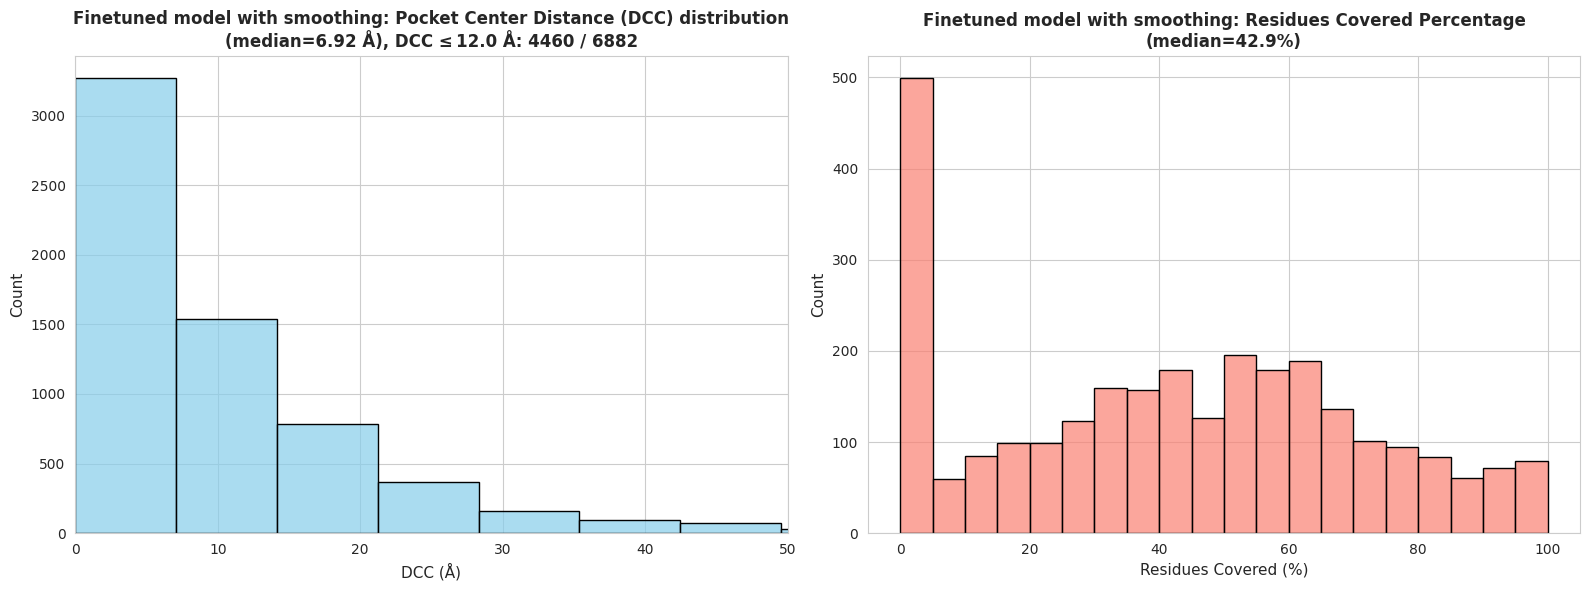

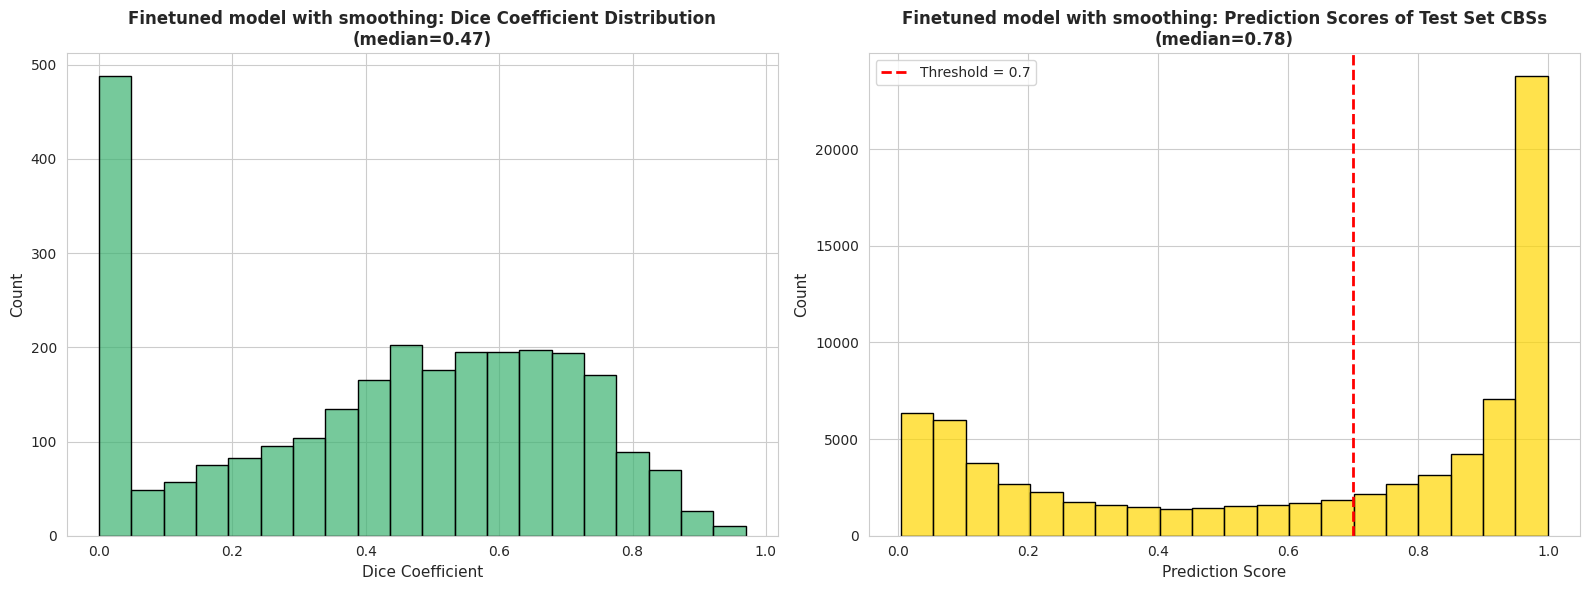

In [65]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

print("Eval method | DCC < 12 | DCC < 4")
for K in [0, 2]:
    predictions = {}
    for protein_id in predicted_binding_sites.keys():
        N = len(binding_residues[protein_id])
        this_predictions = predicted_binding_sites[protein_id][:min(len(predicted_binding_sites[protein_id])-1, N + K)]
        predictions[protein_id] = this_predictions
    DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
    print(f'N+{K}:', np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

## Confusion matrix and MCC calculation 
from sklearn import metrics

actual = []
predicted_with_smoothing = []
predicted_without_smoothing = []

for protein_id in binding_residues.keys():
    this_actual = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site in binding_residues[protein_id]:
        binding_site = [int(i.split('_')[1]) for i in binding_site]
        this_actual[binding_site] = 1
    
    this_predicted_with_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites[protein_id]:
        this_predicted_with_smoothing[binding_site] = 1
    
    this_predicted_without_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites_without_smoothing[protein_id]:
        this_predicted_without_smoothing[binding_site] = 1
    
    predicted_with_smoothing.append(this_predicted_with_smoothing)
    predicted_without_smoothing.append(this_predicted_without_smoothing)
    actual.append(this_actual)

labels = np.concatenate(actual)
predictions_with_smoothing = np.concatenate(predicted_with_smoothing)
predictions_without_smoothing = np.concatenate(predicted_without_smoothing)


print('Conf matrix format: \n[[TN  FP] \n[FN  TP]]\n')
print('clustering & smoothing:\n', metrics.confusion_matrix(labels, predictions_with_smoothing))
print('clustering only:\n', metrics.confusion_matrix(labels, predictions_without_smoothing))

print('MCC:')
print('clustering & smoothing:', metrics.matthews_corrcoef(labels, predictions_with_smoothing))
print('clustering only:', metrics.matthews_corrcoef(labels, predictions_without_smoothing))

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)